# Maximum Likelihood Estimation

## 目的

Hurdle modelを作成するにあたり、MLEの概要をメモする。

## 参考資料
[QuantEcon](https://python.quantecon.org/mle.html)

## MLEとは？
dataが従っている(parametric)確率分布のクラスを指定して、データを用いて未知のパラメーターを推定する方法。

## Counting Billionaires

- [元論文](https://python.quantecon.org/zreferences.html#treisman2016)

#### (1) Install Packages 

In [1]:
pass

#### (2) imports

In [2]:
import numpy as np
from numpy import exp
import scipy
import matplotlib.pyplot as plt
from scipy.special import factorial
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import statsmodels.api as sm
from statsmodels.api import Poisson
from scipy import stats
from scipy.stats import norm
from statsmodels.iolib.summary2 import summary_col

ビリオネアの人数は自然数の値しか取らない。よって、non-negative intergersの値しか取らないような確率分布を考える。その一例として、ポワソン分布。

$$
f(y) = \frac{\mu^{y}}{y!} e^{-\mu},
\qquad y = 0, 1, 2, \ldots, \infty
$$

(3) ポワソン分布をパラメーター $\mu$に応じてplotしてみる

In [3]:
### set parameters
y_values = range(0, 25)

### set poisson pdf
def poisson_pmf(y, mu):
    return (mu**y/factorial(y))*exp(-mu)

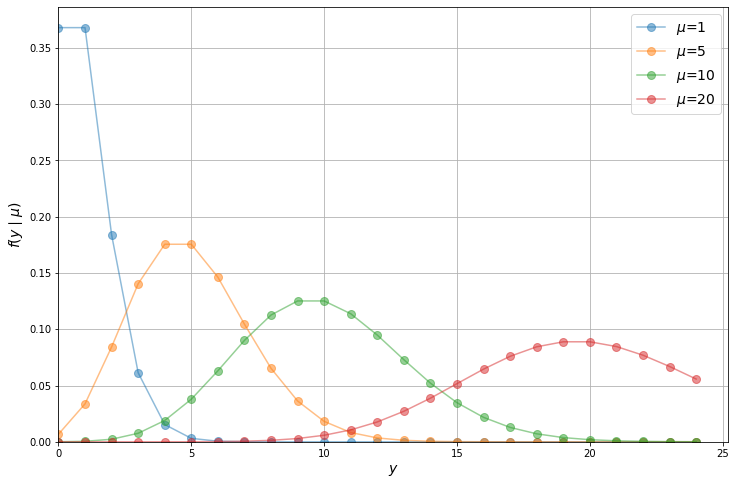

In [4]:
fig, ax = plt.subplots(figsize=(12, 8))

for mu in [1, 5, 10, 20]:
    distribution = []
    for y_i in y_values:
        distribution.append(poisson_pmf(y_i, mu))
    ax.plot(y_values,
            distribution,
            label=f'$\mu$={mu}',
            alpha=0.5,
            marker='o',
            markersize=8)

ax.grid()
ax.set_xlabel('$y$', fontsize=14)
ax.set_ylabel('$f(y \mid \mu)$', fontsize=14)
ax.axis(xmin=0, ymin=0)
ax.legend(fontsize=14);


(4) 論文のデータの読み込み

In [5]:
pd.options.display.max_columns = 10

# Load in data and view
df = pd.read_stata('https://github.com/QuantEcon/lecture-source-py/blob/master/source/_static/lecture_specific/mle/fp.dta?raw=true')
df.head()

,country,ccode,year,cyear,numbil,...,topint08,rintr,noyrs,roflaw,nrrents
0,United States,2.0,1990.0,21990.0,NaN,...,39.799999,4.988405,20.0,1.61,NaN
1,United States,2.0,1991.0,21991.0,NaN,...,39.799999,4.988405,20.0,1.61,NaN
2,United States,2.0,1992.0,21992.0,NaN,...,39.799999,4.988405,20.0,1.61,NaN
3,United States,2.0,1993.0,21993.0,NaN,...,39.799999,4.988405,20.0,1.61,NaN
4,United States,2.0,1994.0,21994.0,NaN,...,39.799999,4.988405,20.0,1.61,NaN


(5) 2008年の各国のビリオネアの人数をplotする

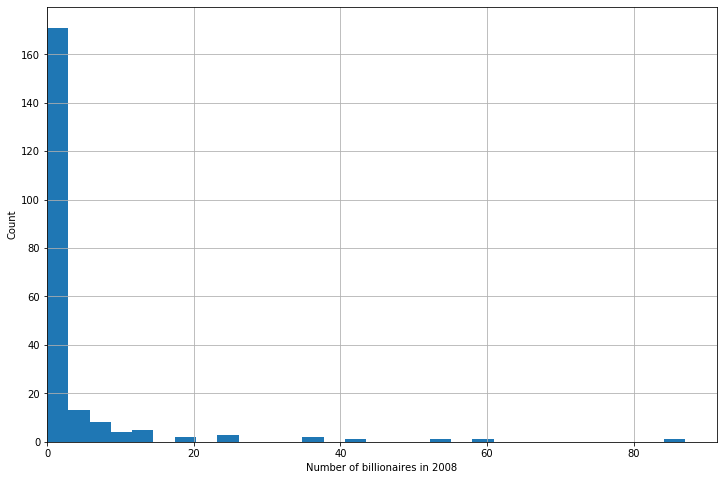

In [6]:
numbil0_2008 = df[(df['year'] == 2008) & (
    df['country'] != 'United States')].loc[:, 'numbil0']

plt.subplots(figsize=(12, 8))
plt.hist(numbil0_2008, bins=30)
plt.xlim(left=0)
plt.grid()
plt.xlabel('Number of billionaires in 2008')
plt.ylabel('Count');

Treismanの元論文ではビリオネアの数は、GDP per capita, population size, GATT and WTOに加入した年で定式化されている。これらがいわゆるpoisson regression modelで表現されるとすると推定式は以下となる

$$
f(y_i \mid \mathbf{x}_i) = \frac{\mu_i^{y_i}}{y_i!} e^{-\mu_i}; \qquad y_i = 0, 1, 2, \ldots , \infty . \tag{1}
$$
$$
\text{where}\ \mu_i
     = \exp(\mathbf{x}_i' \boldsymbol{\beta})
     = \exp(\beta_0 + \beta_1 x_{i1} + \ldots + \beta_k x_{ik})
$$

(6) simulationしてみる

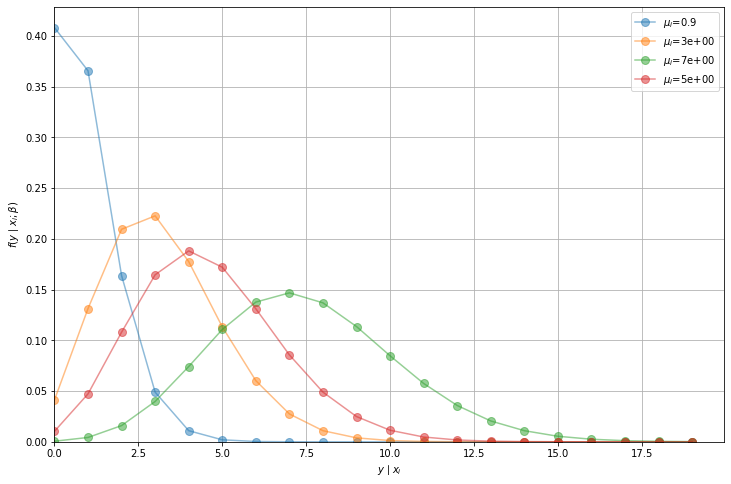

In [7]:
y_values = range(0, 20)

# Define a parameter vector with estimates
beta = np.array([0.26, 0.18, 0.25, -0.1, -0.22])

# Create some observations X, 4 samples
datasets = [np.array([0, 1, 1, 1, 2]),
            np.array([2, 3, 2, 4, 0]),
            np.array([3, 4, 5, 3, 2]),
            np.array([6, 5, 4, 4, 7])]


fig, ax = plt.subplots(figsize=(12, 8))

for X in datasets:
    mu = exp(X @ beta)
    distribution = []
    for y_i in y_values:
        distribution.append(poisson_pmf(y_i, mu))
    ax.plot(y_values,
            distribution,
            label=f'$\mu_i$={mu:.1}',
            marker='o',
            markersize=8,
            alpha=0.5)

ax.grid()
ax.legend()
ax.set_xlabel('$y \mid x_i$')
ax.set_ylabel(r'$f(y \mid x_i; \beta )$')
ax.axis(xmin=0, ymin=0);

## Maximum Likelihood Estimation

4つのパラメーターからなる条件付き分布をでビリオネア推定問題を考える

$$
\beta = \left[\begin{array}{c}\beta_0\\
\beta_1\\
\beta_2\\
\beta_3
\end{array}\right]
$$


これをMLEで推定する時、Likelihoodを最大化させる形で推定する。Likelihhodはjoint probability density functionに相当する。

$y_i = \{y_1, y_2\}$というデータを観測でき、これらがi.i.dならば

$$
f(y_1, y_2) = f(y_1)\cdot f(y_2)
$$

(7) $\lambda = 7$のときのjoint pmfを描く

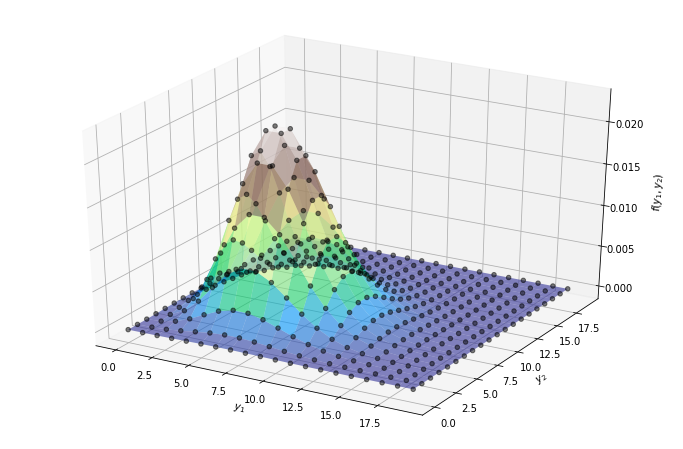

In [8]:
def plot_joint_poisson(mu=7, y_n=20):
    yi_values = np.arange(0, y_n, 1)

    # Create coordinate points of X and Y
    X, Y = np.meshgrid(yi_values, yi_values)

    # Multiply distributions together
    Z = poisson_pmf(X, mu) * poisson_pmf(Y, mu)

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z.T, cmap='terrain', alpha=0.6)
    ax.scatter(X, Y, Z.T, color='black', alpha=0.5, linewidths=1)
    ax.set(xlabel='$y_1$', ylabel='$y_2$')
    ax.set_zlabel('$f(y_1, y_2)$', labelpad=10)
    plt.show()

plot_joint_poisson(mu=7, y_n=20)

もう少し一般化すると

$$
f(y_1, y_2, \ldots, y_n \mid \mathbf{x}_1, \mathbf{x}_2, \ldots, \mathbf{x}_n; \boldsymbol{\beta})
    = \prod_{i=1}^{n} \frac{\mu_i^{y_i}}{y_i!} e^{-\mu_i}
$$

$$
\begin{split}
\mathcal{L}(\beta \mid y_1, y_2, \ldots, y_n \ ; \ \mathbf{x}_1, \mathbf{x}_2, \ldots, \mathbf{x}_n) = &
\prod_{i=1}^{n} \frac{\mu_i^{y_i}}{y_i!} e^{-\mu_i} \\ = &
f(y_1, y_2, \ldots, y_n \mid  \ \mathbf{x}_1, \mathbf{x}_2, \ldots, \mathbf{x}_n ; \beta)
\end{split}
$$

そして、MLEの定式化は

$$
\underset{\boldsymbol{\beta}}{\max} \mathcal{L}(\boldsymbol{\beta})
$$

これをlog-likelihooodで表現すると

$$
\begin{split}
\log{ \mathcal{L}} (\boldsymbol{\beta}) = \ &
    \log \Big(
        f(y_1 ; \boldsymbol{\beta})
        \cdot
        f(y_2 ; \boldsymbol{\beta})
        \cdot \ldots \cdot
        f(y_n ; \boldsymbol{\beta})
        \Big) \\
        = &
        \sum_{i=1}^{n} \log{f(y_i ; \boldsymbol{\beta})} \\
        = &
        \sum_{i=1}^{n}
        \log \Big( {\frac{\mu_i^{y_i}}{y_i!} e^{-\mu_i}} \Big) \\
        = &
        \sum_{i=1}^{n} y_i \log{\mu_i} -
        \sum_{i=1}^{n} \mu_i -
        \sum_{i=1}^{n} \log y!
\end{split}
$$

### REMARKS
上の問題を解析的に解く手法はなく、そのため数値計算で解かなくてはならない。

## MLE with Numerical Method
Newton-Raphson algorithmを用いて問題を解いてみる。

なお推定量$\hat\beta$ではlog-likelihoodのFOCは0に等しくなる。

$$
\log \mathcal{L(\beta)} = - (\beta - 10) ^2 - 10
$$
を例にplotしてみる。

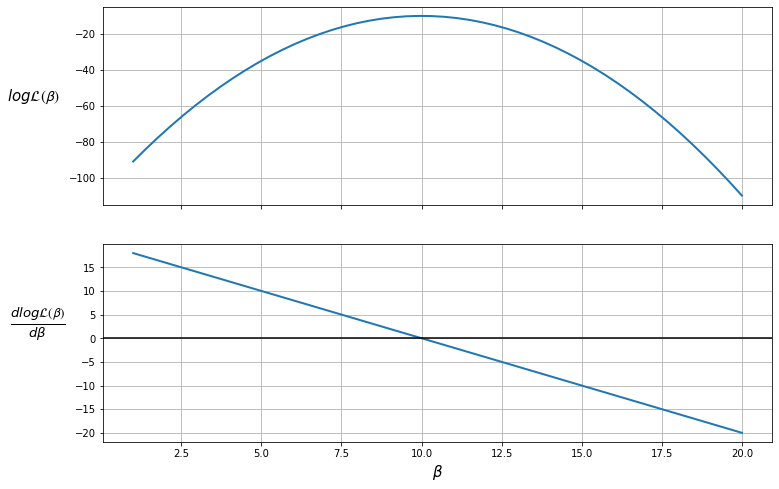

In [9]:
beta = np.linspace(1, 20)
logL = - (beta - 10) ** 2 - 10
dlogL = -2 * beta + 20

fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(12, 8))

ax1.plot(beta, logL, lw=2)
ax2.plot(beta, dlogL, lw=2)

ax1.set_ylabel(r'$log \mathcal{L(\beta)}$',
               rotation=0,
               labelpad=35,
               fontsize=15)
ax2.set_ylabel(r'$\frac{dlog \mathcal{L(\beta)}}{d \beta}$ ',
               rotation=0,
               labelpad=35,
               fontsize=19)
ax2.set_xlabel(r'$\beta$', fontsize=15)
ax1.grid(), ax2.grid()
plt.axhline(c='black')
plt.show()

## Newton-Raphson algorithm

- First derivativeの値が0に等しいpointを見つけるアルゴリズム
- initial guessはOLSのパラメーターを代入するのが一般的

### Algorithm in detail
#### 1: the updating rule to iterate the algorithm
$$
\boldsymbol{\beta}_{(k+1)} = \boldsymbol{\beta}_{(k)} - H^{-1}(\boldsymbol{\beta}_{(k)})G(\boldsymbol{\beta}_{(k)})
$$
where:

$$
\begin{aligned}
G(\boldsymbol{\beta}_{(k)}) = \frac{d \log \mathcal{L(\boldsymbol{\beta}_{(k)})}}{d \boldsymbol{\beta}_{(k)}} \\
H(\boldsymbol{\beta}_{(k)}) = \frac{d^2 \log \mathcal{L(\boldsymbol{\beta}_{(k)})}}{d \boldsymbol{\beta}_{(k)}d \boldsymbol{\beta}'_{(k)}}
\end{aligned}
$$

#### 2: check whether $\boldsymbol{\beta}_{(k+1)} - \boldsymbol{\beta}_{(k)} < tol$
- if true, stop the iteration
- if false, update $\beta_{(k+1)}$

このupdateing ruleからもわかるように$G(\beta_k) = 0$のときupdateが終了する。

### Newton-Raphson algorithmの実装 

iterationの度に、Hessian, Gradient, log-likelihoodclassのvalueの計算がしやすくなるよう（データの受け渡しが簡単になるようにするため）`class`をまず定義する

In [10]:
class poisson_regression:
    
    def __init__(self, y, X, beta):
        self.X = X
        self.n, self.k = X.shape
        self.y = y.reshape(self.n, 1)
        self.beta = beta.reshape(self.k, 1)
        
    def mu(self):
        return np.exp(self.X @ self.beta)
    
    def logL(self):
        y = self.y
        mu = self.mu()
        return np.sum(y * np.log(mu) - mu - np.log(factorial(y)))
    
    def G(self):
        # grandient
        y = self.y
        mu = self.mu()
        return X.T @ (y - mu)
    
    def H(self):
        X = self.X
        mu = self.mu()
        return -(X.T @ (mu * X))

アルゴリズムの実装

In [11]:
def newton_raphson(model, tol=1e-3, max_iter=5000, display=True):

    i = 0
    error = 100  # Initial error value

    # Print header of output
    if display:
        header = f'{"Iteration_k":<13}{"Log-likelihood":<16}{"θ":<60}'
        print(header)
        print("-" * len(header))

    while np.any(error > tol) and i < max_iter:
        H, G = model.H(), model.G()
        beta_new = model.beta - (np.linalg.inv(H) @ G)
        error = beta_new - model.beta
        model.beta = beta_new

        # Print iterations
        if display:
            beta_list = [f'{t:.3}' for t in list(model.beta.flatten())]
            update = f'{i:<13}{model.logL():<16.8}{beta_list}'
            print(update)

        i += 1

    print(f'Number of iterations: {i}')
    print(f'beta_hat = {model.beta.flatten()}')

    # Return a flat array for β (instead of a k_by_1 column vector)
    return model.beta.flatten()

テスト

In [12]:
X = np.array([[1, 2, 5],
              [1, 1, 3],
              [1, 4, 2],
              [1, 5, 2],
              [1, 3, 1]])

y = np.array([1, 0, 1, 1, 0])
init_beta = np.array([0.1, 0.1, 0.1])

# Create an object with Poisson model values
poi = poisson_regression(y, X, beta=init_beta)

# Use newton_raphson to find the MLE
beta_hat = newton_raphson(poi, display=True)

Iteration_k  Log-likelihood  θ                                                           
-----------------------------------------------------------------------------------------
0            -4.3447622      ['-1.49', '0.265', '0.244']
1            -3.5742413      ['-3.38', '0.528', '0.474']
2            -3.3999526      ['-5.06', '0.782', '0.702']
3            -3.3788646      ['-5.92', '0.909', '0.82']
4            -3.3783559      ['-6.07', '0.933', '0.843']
5            -3.3783555      ['-6.08', '0.933', '0.843']
Number of iterations: 6
beta_hat = [-6.07848205  0.93340226  0.84329625]


In [13]:
poi.G()

array([[-3.95169228e-07],
       [-1.00114805e-06],
       [-7.73114562e-07]])

### Standard Errors of MLE

standard errorはFisher information matrixの逆行列の対角要素を抽出することで計算できる。

$$
\mathbb{V}{\rm ar}(\boldsymbol{\gamma}) = \left[ \mathbf{I}(\widehat{\boldsymbol{\gamma}}_{\text{ML}}) \right]^{-1}
$$

Fisher information matrixは

$$
\left(\mathbf{I}(\boldsymbol{\gamma}) \right)_{i,j} = -\dfrac{\partial^2 }{\partial \gamma_i \partial \gamma_j}\mathcal{\ell}(\boldsymbol{\gamma}),\quad 1 \leq i,j \leq p
$$


negative loh-likelihood functionを用いて再消化問題を解く時は、その時得られるHessianをそのまま持ちいれば良い。likelihood function最大化の場合は、

$$
\mathbf{I}(\widehat{\boldsymbol{\gamma}}_{\text{ML}}) = - \mathbf{H}(\widehat{\boldsymbol{\gamma}}_{\text{ML}})
$$

漸近分布は

$$
\widehat{\boldsymbol{\gamma}}_{\text{ML}} \sim \mathcal{N} \left(\boldsymbol{\gamma}, \left[ \mathbf{I}(\widehat{\boldsymbol{\gamma}}_{\text{ML}}) \right]^{-1} \right)
$$

次に実装してみる。今回はめんどくさいのでscipyを用いてパラメーターの推定および検定まで実施する。

In [14]:
import scipy.optimize as optimize

In [15]:
def log_lik(beta, y, X):
    mu = np.exp(X @ beta)
    return - np.sum(y * np.log(mu) - mu - np.log(factorial(y)))
    

beta_hat = [-6.07848205  0.93340226  0.84329625]

In [16]:
y.shape, X.shape

((5,), (5, 3))

In [17]:
opt_res = optimize.minimize(fun = log_lik, 
                            x0 = [0, 0, 1], 
                            args = (y, X))
print(opt_res)

      fun: 3.378355505227862
 hess_inv: array([[28.29795354, -4.31932638, -4.05699431],
       [-4.31932638,  0.70723932,  0.58090116],
       [-4.05699431,  0.58090116,  0.64310157]])
      jac: array([-4.17232513e-07, -4.38094139e-06,  4.82797623e-06])
  message: 'Optimization terminated successfully.'
     nfev: 95
      nit: 16
     njev: 19
   status: 0
  success: True
        x: array([-6.07849637,  0.93340404,  0.84329875])


In [18]:
## MLEで推定されたパラメーター
opt_res.x

array([-6.07849637,  0.93340404,  0.84329875])

In [19]:
## variance covariance matrix
print(opt_res.hess_inv)

[[28.29795354 -4.31932638 -4.05699431]
 [-4.31932638  0.70723932  0.58090116]
 [-4.05699431  0.58090116  0.64310157]]


In [20]:
## standard error
standard_error = np.sqrt(np.diag(opt_res.hess_inv))
standard_error

array([5.31958208, 0.84097522, 0.80193614])

なおpoisson_regressionのHessianの逆行列を計算すると

In [21]:
np.linalg.inv(-poi.H())

array([[27.86863208, -4.2330369 , -4.00472156],
       [-4.2330369 ,  0.68694063,  0.57141825],
       [-4.00472156,  0.57141825,  0.63650716]])

傾向は同じだが、この場合はscipyを信用するとする。

### 検定方法(t test)

In [22]:
sample_size = X.shape[0]
estimates = opt_res.x
k = len(estimates)
degree_of_freedom = sample_size - k


for i in range(0,k):
    test_statistic = estimates[i]/standard_error[i]
    cdf = scipy.stats.t.cdf(test_statistic , degree_of_freedom)
    if estimates[i] < 0:
        p_val = cdf
    else:
        p_val = 1 - cdf
    print('coefficient-{}, test_statistic: {}, p-val: {}\n'.format(i, test_statistic, p_val))

coefficient-0, test_statistic: -1.1426642690065507, p-val: 0.18576240715742498

coefficient-1, test_statistic: 1.1099067113180607, p-val: 0.1913061331070578

coefficient-2, test_statistic: 1.0515784379828743, p-val: 0.20165158789870496



### Maximum Likelihood Estimation with statsmodels

In [23]:
stats_poisson = Poisson(y, X).fit()
print(stats_poisson.summary())

Optimization terminated successfully.
         Current function value: 0.675671
         Iterations 7
                          Poisson Regression Results                          
Dep. Variable:                      y   No. Observations:                    5
Model:                        Poisson   Df Residuals:                        2
Method:                           MLE   Df Model:                            2
Date:                Wed, 19 Feb 2020   Pseudo R-squ.:                  0.2546
Time:                        04:16:27   Log-Likelihood:                -3.3784
converged:                       True   LL-Null:                       -4.5325
Covariance Type:            nonrobust   LLR p-value:                    0.3153
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.0785      5.279     -1.151      0.250     -16.425       4.268
x1             0.9334      0.

## ビリオネア論文の推定と検定 with `statsmodels`

In [24]:
# Keep only year 2008
df = df[df['year'] == 2008]

# Add a constant
df['const'] = 1

# Variable sets
reg1 = ['const', 'lngdppc', 'lnpop', 'gattwto08']
reg2 = ['const', 'lngdppc', 'lnpop',
        'gattwto08', 'lnmcap08', 'rintr', 'topint08']
reg3 = ['const', 'lngdppc', 'lnpop', 'gattwto08', 'lnmcap08',
        'rintr', 'topint08', 'nrrents', 'roflaw']

In [25]:
regs = [reg1, reg2, reg3]
reg_names = ['Model 1', 'Model 2', 'Model 3']
info_dict = {'Pseudo R-squared': lambda x: f"{x.prsquared:.2f}",
             'No. observations': lambda x: f"{int(x.nobs):d}"}
regressor_order = ['const',
                   'lngdppc',
                   'lnpop',
                   'gattwto08',
                   'lnmcap08',
                   'rintr',
                   'topint08',
                   'nrrents',
                   'roflaw']
results = []

for reg in regs:
    result = sm.Poisson(df[['numbil0']], df[reg],
                        missing='drop').fit(cov_type='HC0',
                                            maxiter=100, disp=0)
    results.append(result)

results_table = summary_col(results=results,
                            float_format='%0.3f',
                            stars=True,
                            model_names=reg_names,
                            info_dict=info_dict,
                            regressor_order=regressor_order)
results_table.add_title('Table 1 - Explaining the Number of Billionaires \
                        in 2008')
print(results_table)

Table 1 - Explaining the Number of Billionaires                         in 2008
                  Model 1    Model 2    Model 3  
-------------------------------------------------
const            -29.050*** -19.444*** -20.858***
                 (2.578)    (4.820)    (4.255)   
lngdppc          1.084***   0.717***   0.737***  
                 (0.138)    (0.244)    (0.233)   
lnpop            1.171***   0.806***   0.929***  
                 (0.097)    (0.213)    (0.195)   
gattwto08        0.006      0.007      0.004     
                 (0.007)    (0.006)    (0.006)   
lnmcap08                    0.399**    0.286*    
                            (0.172)    (0.167)   
rintr                       -0.010     -0.009    
                            (0.010)    (0.010)   
topint08                    -0.051***  -0.058*** 
                            (0.011)    (0.012)   
nrrents                                -0.005    
                                       (0.010)   
roflaw              

GDP per capita, population size, market capitalization level, 高所得者 tax rateが重要な要素であると解釈することができる

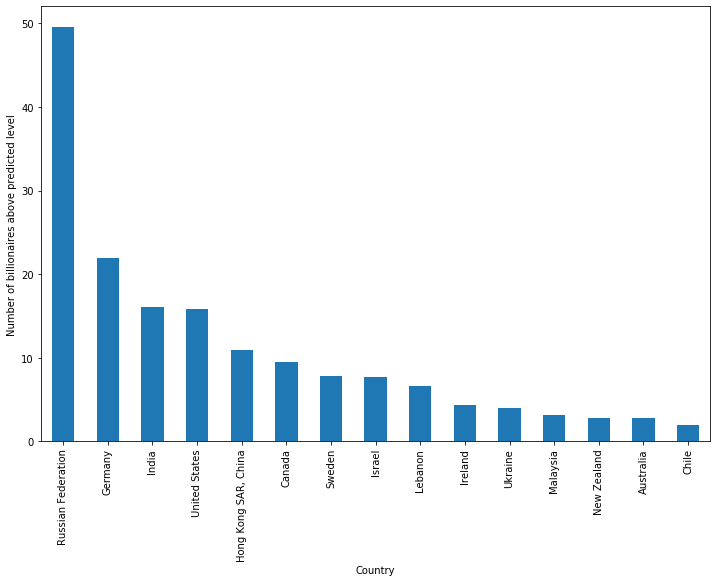

In [26]:
data = ['const', 'lngdppc', 'lnpop', 'gattwto08', 'lnmcap08', 'rintr',
        'topint08', 'nrrents', 'roflaw', 'numbil0', 'country']
results_df = df[data].dropna()

# Use last model (model 3)
results_df['prediction'] = results[-1].predict()

# Calculate difference
results_df['difference'] = results_df['numbil0'] - results_df['prediction']

# Sort in descending order
results_df.sort_values('difference', ascending=False, inplace=True)

# Plot the first 15 data points
results_df[:15].plot('country', 'difference', kind='bar',
                    figsize=(12,8), legend=False)
plt.ylabel('Number of billionaires above predicted level')
plt.xlabel('Country')
plt.show()

ロシアやばい。。。

## 復習問題

### Exercise 1

$$
\begin{aligned}
f(y_i; \boldsymbol{\beta}) = \mu_i^{y_i} (1-\mu_i)^{1-y_i}, \quad y_i = 0,1 \\
\text{where} \quad \mu_i = \Phi(\mathbf{x}_i' \boldsymbol{\beta})
\end{aligned}
$$

このときのbetaを推定せよ

In [27]:
def log_lik_probit(beta, y, X):
    mu = scipy.stats.norm.cdf(X @ beta)
    return - np.sum(y * np.log(mu) + (1 - y)*np.log(1 - mu))

def estimation(y, X, initial_val, model):
    opt_res = optimize.minimize(fun = model, 
                            x0 = initial_val, 
                            args = (y, X))
    coefficients = opt_res.x
    standard_error = np.sqrt(np.diag(opt_res.hess_inv))
    return (coefficients, standard_error)


In [28]:
X = np.array([[1, 2, 4],
              [1, 1, 1],
              [1, 4, 3],
              [1, 5, 6],
              [1, 3, 5]])

y = np.array([1, 0, 1, 1, 0])
estimation(y, X, [-2,  0, 0], log_lik_probit)

(array([-1.54625814,  0.77778952, -0.09709768]),
 array([1.84765256, 0.79027546, 0.58791075]))

In [29]:
### statsmodel
print(sm.Probit(y, X).fit().summary())

Optimization terminated successfully.
         Current function value: 0.473746
         Iterations 6
                          Probit Regression Results                           
Dep. Variable:                      y   No. Observations:                    5
Model:                         Probit   Df Residuals:                        2
Method:                           MLE   Df Model:                            2
Date:                Wed, 19 Feb 2020   Pseudo R-squ.:                  0.2961
Time:                        04:16:28   Log-Likelihood:                -2.3687
converged:                       True   LL-Null:                       -3.3651
Covariance Type:            nonrobust   LLR p-value:                    0.3692
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.5463      1.866     -0.829      0.407      -5.204       2.111
x1             0.7778      0.

### REMARKS
- ここでは深くは述べないが、一般的にMLE推定量はconnsistentだがunbiasedではない